# Project 2: Covid X-ray dataset
Mathis (mm6712) and Xiyun (xh2604)

## Visualizing images and geneal description of the dataset

### Import in google colab

In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

### Import from local folder

In [3]:
# import zipfile
# import os

# # Path to the zip file
# zip_file_path = "COVID-19_Radiography_Dataset.zip"  # Replace with your actual zip file path

# # Get the directory where the zip file is located
# extract_to_path = os.path.dirname(zip_file_path)

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents into the same directory
#     zip_ref.extractall(extract_to_path)

# print(f"Files extracted to: {extract_to_path}")

### Import main packages

In [19]:

# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import random

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

### Format and preprocess data

In [5]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
# print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [6]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


### Labeling the data

In [10]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas


y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0      True   False      False
1      True   False      False
2      True   False      False
3      True   False      False
4      True   False      False
...     ...     ...        ...
4027  False   False       True
4028  False   False       True
4029  False   False       True
4030  False   False       True
4031  False   False       True

[4032 rows x 3 columns]

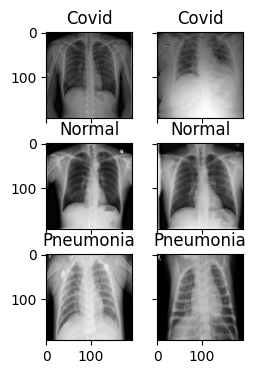

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][0])
im4 =preprocessor(fnames[1][1])
im5 =preprocessor(fnames[2][0])
im6 =preprocessor(fnames[2][1])

titles = ['Covid', 'Covid', 'Normal', 'Normal', 'Pneumonia', 'Pneumonia']

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im, titles in zip(grid, [im1, im2, im3, im4, im5, im6], titles):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_title(titles)
plt.show()

Description:
* The dataset consists of 4032 images. The three categories, X-ray,
covid-positive, normal, and pneumonia each have 1344 images. The images are resized into 192x192.

Implications:
* Building a predictive model using this data can aid diagnosis, especially in differentiating covid from the regular pneumonia. Medical practitioners can make better judgments and patients can get more targeted treatments.

* It is also cheaper and faster that usual chemical tests for COVID-19, and depending on the model, it may also be more reliable!

* During time of pandemics, these advantages may be very interesting to efficiently know who is sick and who isn't.

## Prediction Models

In [12]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [13]:
#Clear objects from memory
del(X)
# del(y)
del(preprocessed_image_data)

In [14]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [2]:
#If you run out of memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

with open('y_test.pkl', 'rb') as file:
    # Call load method to deserialze
    y_test = pickle.load(file)

# CNN

In [3]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [4]:
def plot_accuracy(model):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(model.history.history['acc'])
  plt.plot(model.history.history['val_acc'])
  plt.legend(['Training', 'Validation'])
  plt.show()

## VGG16

In [5]:
#loading VGG16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

model = VGG16(input_shape=(192,192,3),classes = 3, weights=None) #create a VGG16 model with 3 output classes
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │      75,501,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 107,009,859 (408.21 MB)

 Trainable params: 107,009,859 (408.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit VGG16 model
with tf.device('/device:GPU:0'):

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) # compiling

  model.fit(X_train, y_train,batch_size=4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr]) # fitting

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - acc: 0.3571 - loss: 1.0930
Epoch 1: val_acc improved from -inf to 0.48998, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - acc: 0.3572 - loss: 1.0929 - val_acc: 0.4900 - val_loss: 0.9096 - learning_rate: 0.0100
Epoch 2/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - acc: 0.6717 - loss: 0.7428
Epoch 2: val_acc improved from 0.48998 to 0.68124, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - acc: 0.6717 - loss: 0.7426 - val_acc: 0.6812 - val_loss: 0.6658 - learning_rate: 0.0100
Epoch 3/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.7690 - loss: 0.5477
Epoch 3: val_acc improved from 0.68124 to 0.77960, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - acc: 0.7690 - loss: 0.5476 - val_acc: 0.7796 - val_loss: 0.4941 - learning_rate: 0.0100
Epoch 4/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 0.8003 - loss: 0.4527
Epoch 4: val_acc did not

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455]
Best model epoch: 14


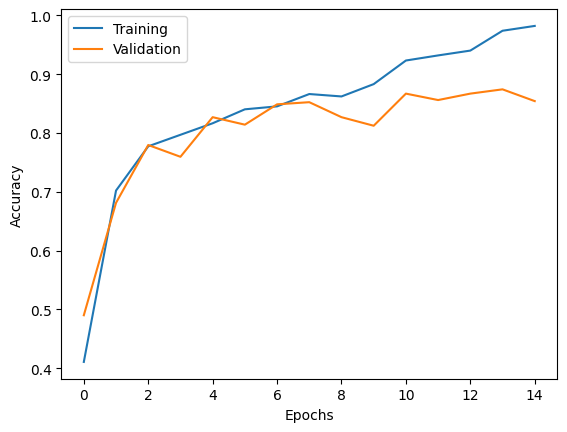

In [ ]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


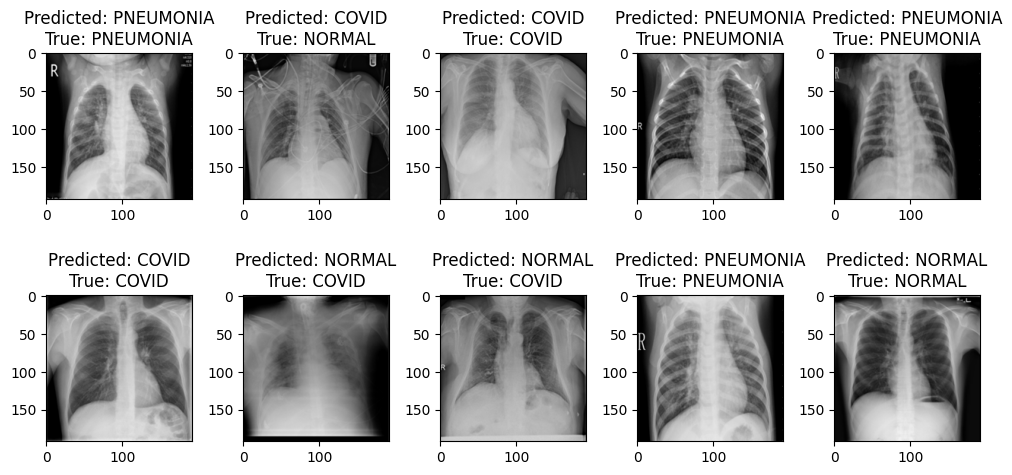

In [ ]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step


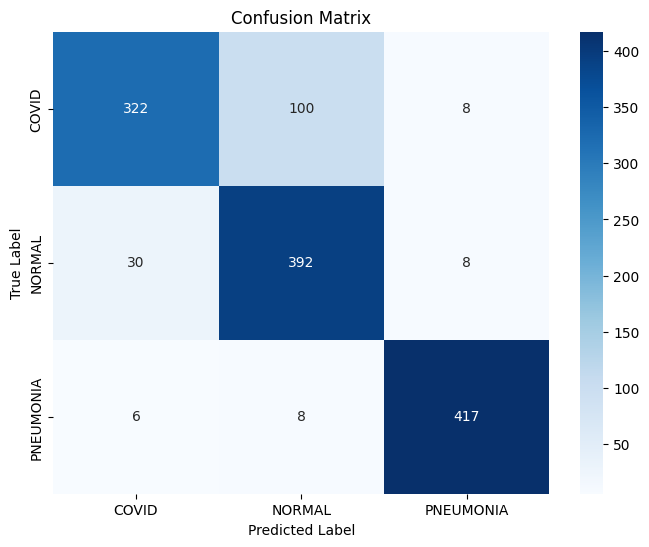

Accuracy:  0.8760650658404338
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82       430
           1       0.78      0.91      0.84       430
           2       0.96      0.97      0.97       431

    accuracy                           0.88      1291
   macro avg       0.88      0.88      0.88      1291
weighted avg       0.88      0.88      0.88      1291



In [ ]:
predictions = model.predict(X_test) # Calculate predictions for the full test sample
predicted_classes = np.argmax(predictions, axis=1) #extract the most probable class

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes) #Calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1) #turn the test results into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes) #make the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on VGG16

The VGG16 model has a pretty good accuracy of 88%, but it gesses some Normal as Covid and a lot Covid as normal, which isn't great in our case. Of course, this big model without transfer could deserve more training (it seems undertrained here) and could also benefit from data augmentation to prevent over-training on our rather small initial sample.

## ResNET50

In [5]:
# example of loading the ResNET model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model ResNet50
model = ResNet50(input_shape=IMG_SHAPE, weights=None, classes = 3)

model.summary() # Notice unfrozen number of trainable parameters

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Fit Resnet model
import tensorflow as tf
with tf.device('/device:GPU:0'):
  from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) #compiling

  model.fit(X_train, y_train,batch_size=4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr]) #training

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.4939 - loss: 2.9525
Epoch 1: val_acc improved from -inf to 0.69763, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - acc: 0.4939 - loss: 2.9507 - val_acc: 0.6976 - val_loss: 0.8486 - learning_rate: 0.0100
Epoch 2/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.6754 - loss: 0.8645
Epoch 2: val_acc improved from 0.69763 to 0.75410, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - acc: 0.6754 - loss: 0.8645 - val_acc: 0.7541 - val_loss: 0.5466 - learning_rate: 0.0100
Epoch 3/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.7239 - loss: 0.6893
Epoch 3: val_acc did not improve from 0.75410
548/548 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - acc: 0.7239 - loss: 0.6892 - val_acc: 0.7541 - val_loss: 0.6247 - learning_rate: 0.0100
Epoch 4/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.7460 - loss: 0.6175
Epoch 4: val_acc improved from 0.75410 to 0.76867, saving mode

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455]
Best model epoch: 15


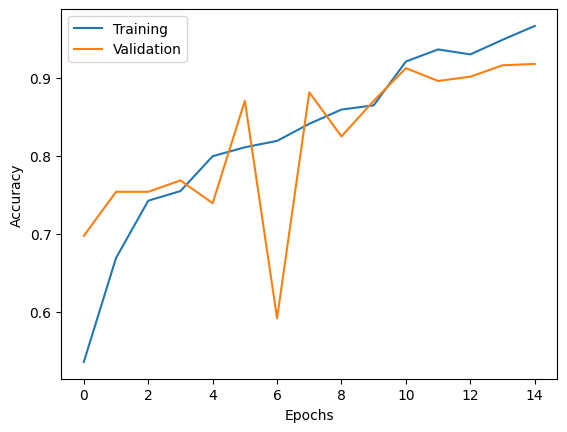

In [ ]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


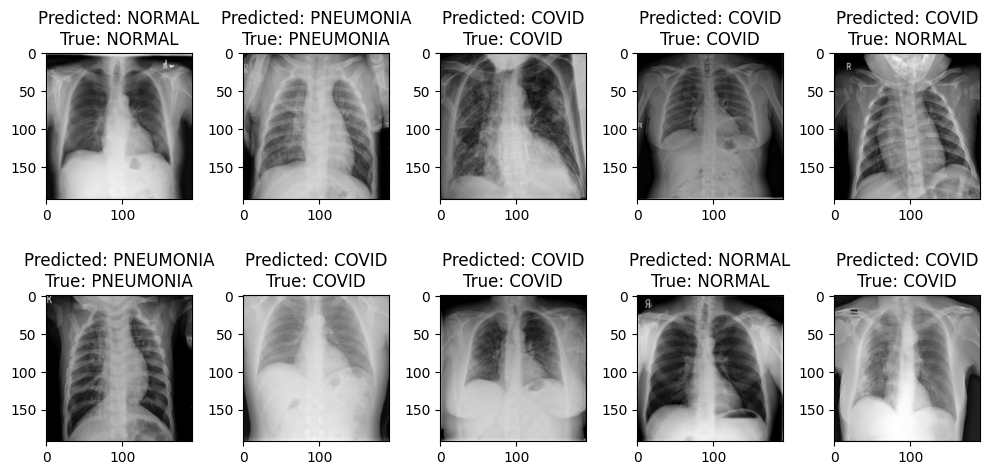

In [ ]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step


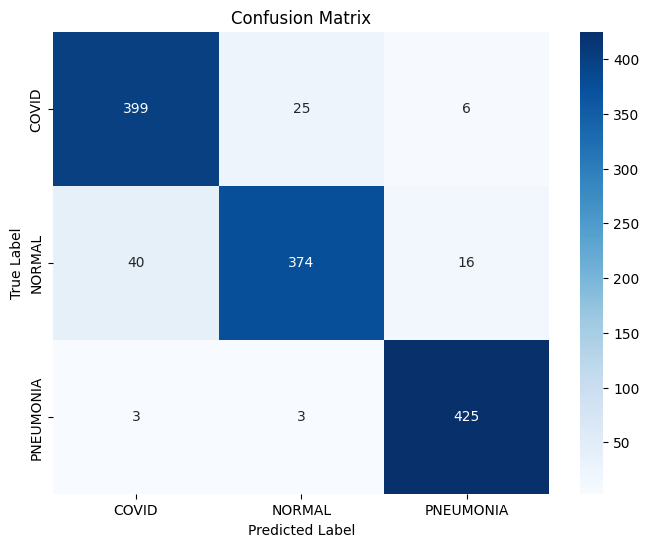

Accuracy:  0.9279628195197521
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       430
           1       0.93      0.87      0.90       430
           2       0.95      0.99      0.97       431

    accuracy                           0.93      1291
   macro avg       0.93      0.93      0.93      1291
weighted avg       0.93      0.93      0.93      1291



In [ ]:
predictions = model.predict(X_test)#calculate the prediction on the test set.
predicted_classes = np.argmax(predictions, axis=1)#extract the most probable class

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes) # calculate the confusion matrix

#represent the confusion mtrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1) #convert test results to list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes) #calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on ResNET50

The ResNET50 model has a very good accuracy of 93%.
It still has some confusion (mostly between Normal and Covid pictures) and could benefit more training (it seems undertrained here).

## InceptionV3

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
model = InceptionV3(input_shape=IMG_SHAPE, classes = 3, weights=None)

model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 95, 95, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 95, 95, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 95, 95, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 93, 93, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 93, 93, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 93, 93, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 93, 93, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 93, 93, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 93, 93, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 46, 46, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 46, 46, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 46, 46, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 46, 46, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 44, 44, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 44, 44, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Fit InceptionV3 model
with tf.device('/device:GPU:0'):

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])#compiling

  model.fit(X_train, y_train, batch_size = 4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr]) #training

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.4739 - loss: 1.2172
Epoch 1: val_acc improved from -inf to 0.73042, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 84s 64ms/step - acc: 0.4740 - loss: 1.2169 - val_acc: 0.7304 - val_loss: 0.6466 - learning_rate: 0.0100
Epoch 2/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.6407 - loss: 0.8634
Epoch 2: val_acc did not improve from 0.73042
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - acc: 0.6408 - loss: 0.8632 - val_acc: 0.5209 - val_loss: 1.3439 - learning_rate: 0.0100
Epoch 3/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.7187 - loss: 0.7174
Epoch 3: val_acc improved from 0.73042 to 0.83424, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - acc: 0.7187 - loss: 0.7174 - val_acc: 0.8342 - val_loss: 0.4351 - learning_rate: 0.0100
Epoch 4/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.7652 - loss: 0.5817
Epoch 4: val_acc did not improve from 0.83424
548/548 ━━━━━━━━

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455, 0.0024999999441206455, 0.0024999999441206455]
Best model epoch: 15


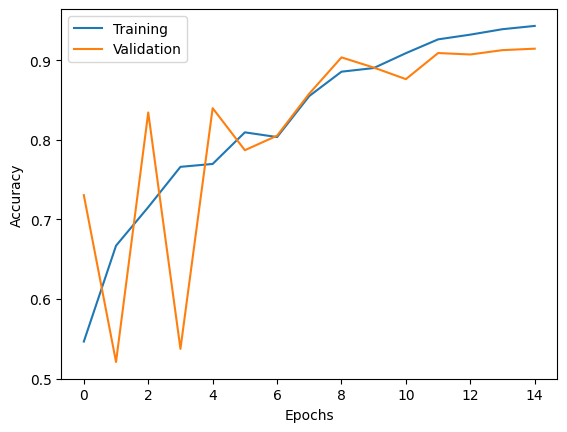

In [ ]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


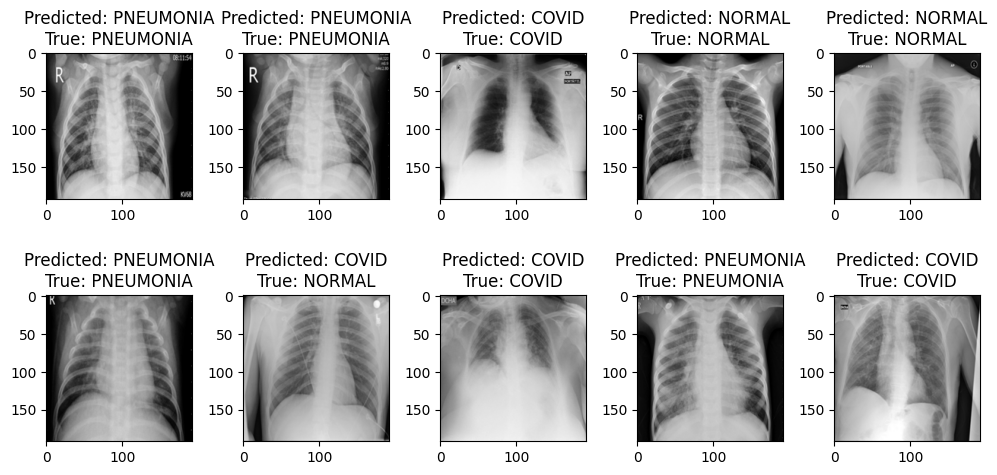

In [ ]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step


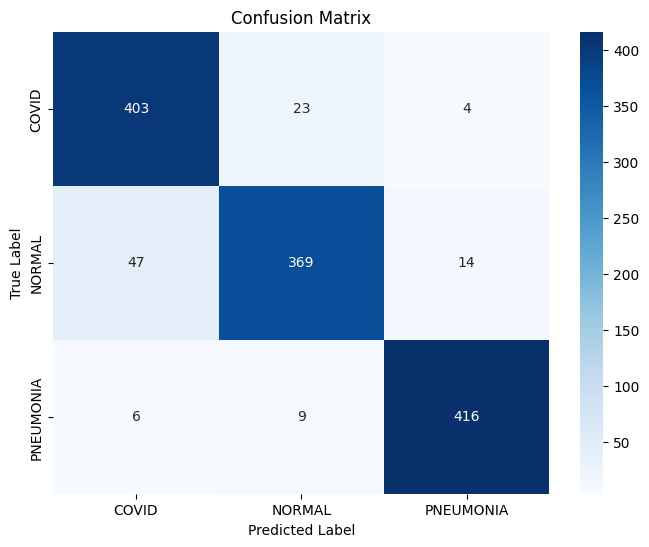

Accuracy:  0.9202168861347793
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       430
           1       0.92      0.86      0.89       430
           2       0.96      0.97      0.96       431

    accuracy                           0.92      1291
   macro avg       0.92      0.92      0.92      1291
weighted avg       0.92      0.92      0.92      1291



In [ ]:
predictions = model.predict(X_test) #calculate the prediction over the test set
predicted_classes = np.argmax(predictions, axis=1) # extract the most probable class

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes) #calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1) #turn the test labels into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes) #calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on InceptionV3

The InceptionV3 has very similar results to the ResNET50 above. There is still some confusion between Covid and Normal, and the accuracy is of 92%.

## General comment on intitial CNN models and hyper-parameters

For the size of the dataset, and with the given amount of training, InceptionV3 and ResNET50 are more efficient thant VGG16. This may be due to the number of trainable parameters, with VGG16 having 4 times more trainable parameters than the two other models.

The main parameters that improved models efficiency was the batch size. Using smallet batch allows for more frequent weight updates gradient optimizing, leading to far better result but also more calculation time.

Choosing the "SDG" optimizer instead of "Adam" also prooved to be far better for our models.

Other hyper-parameters still have some limited influence, and son't seem to matter that much if kept into a given range.

# Transfer Learning
The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training in order to reduce calculation time. We pre-train the models on imagenet.


## VGG16 transfer model

In [ ]:
# Create the base model from the pre-trained model VGG16
base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.
base_model.trainable = False
base_model.summary() #the trainable parameters at the bottom now equal zero.

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 96, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 48, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 112)                 │       2,064,496 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,779,523 (64.01 MB)

 Trainable params: 2,064,835 (7.88 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Fit VGG16 model with frozen ImageNet weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'):
  from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])#compiling

  model.fit(X_train, y_train,batch_size=4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr])#training

Epoch 1/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.4450 - loss: 1.1996
Epoch 1: val_acc improved from -inf to 0.67213, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - acc: 0.4454 - loss: 1.1986 - val_acc: 0.6721 - val_loss: 0.5788 - learning_rate: 0.0100
Epoch 2/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.7360 - loss: 0.6381
Epoch 2: val_acc improved from 0.67213 to 0.85610, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - acc: 0.7362 - loss: 0.6378 - val_acc: 0.8561 - val_loss: 0.4163 - learning_rate: 0.0100
Epoch 3/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8268 - loss: 0.4473
Epoch 3: val_acc did not improve from 0.85610
548/548 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - acc: 0.8268 - loss: 0.4472 - val_acc: 0.7231 - val_loss: 0.7250 - learning_rate: 0.0100
Epoch 4/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8593 - loss: 0.3539
Epoch 4: val_acc improved from 0.85610 to 0.88342, saving mode

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455, 0.0024999999441206455, 0.0012499999720603228]
Best model epoch: 12


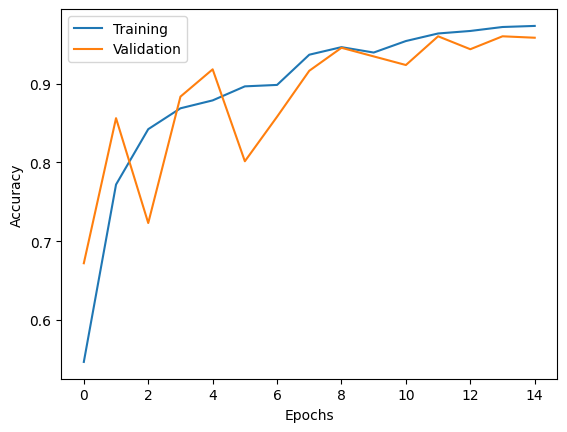

In [ ]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


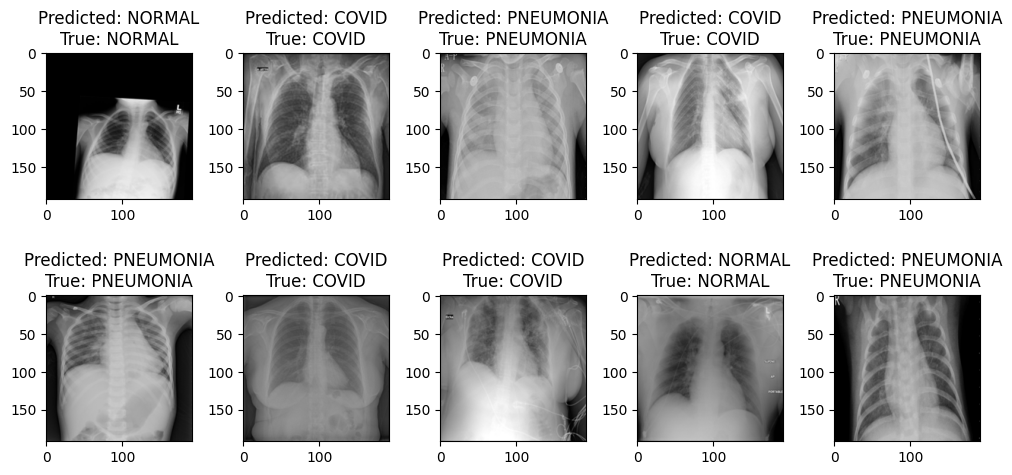

In [ ]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step


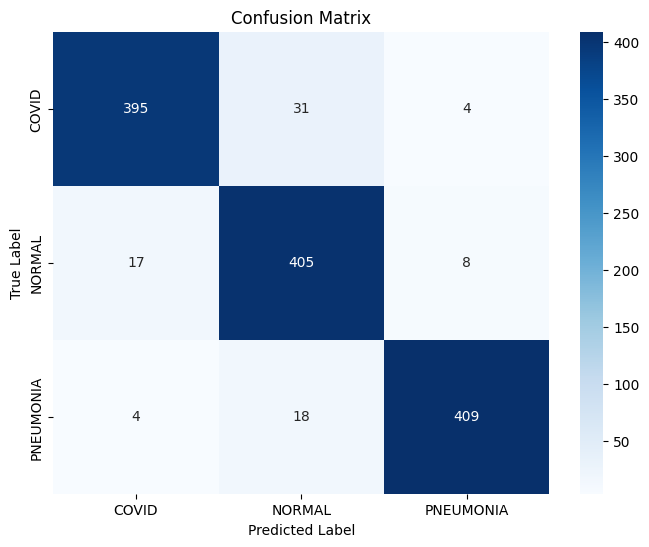

Accuracy:  0.9364833462432223
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       430
           1       0.89      0.94      0.92       430
           2       0.97      0.95      0.96       431

    accuracy                           0.94      1291
   macro avg       0.94      0.94      0.94      1291
weighted avg       0.94      0.94      0.94      1291



In [ ]:
predictions = model.predict(X_test)# calculate the prediction over the test set
predicted_classes = np.argmax(predictions, axis=1)# extract the most probable classes

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes)# calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1)#turn the test labels into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes)# calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on VGG16 with transfer learning

The transfert learning has improved the accuracy from 88% to 94%, thus being very efficient in reducing Normal and Covid confusion. Some more training could still be benificial though.

## ResNET50 transfert model

In [18]:
# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model ResNet50
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
# Add new GAP layer and output layer to non-froozen layers of original model with adjusted input


# Getting output tensor of the last ResNET50 layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the ResNET50 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
# Fit ResNET50 model with non-frozen ImageNet weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'):
  from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])#compiling

  model.fit(X_train, y_train,batch_size=4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr])#fiting

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.7598 - loss: 0.6320
Epoch 1: val_acc improved from -inf to 0.33698, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 91s 71ms/step - acc: 0.7599 - loss: 0.6317 - val_acc: 0.3370 - val_loss: 1.5980 - learning_rate: 0.0100
Epoch 2/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.9459 - loss: 0.1650
Epoch 2: val_acc improved from 0.33698 to 0.89071, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - acc: 0.9459 - loss: 0.1649 - val_acc: 0.8907 - val_loss: 0.2750 - learning_rate: 0.0100
Epoch 3/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - acc: 0.9782 - loss: 0.0609
Epoch 3: val_acc improved from 0.89071 to 0.96539, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - acc: 0.9782 - loss: 0.0609 - val_acc: 0.9654 - val_loss: 0.1086 - learning_rate: 0.0100
Epoch 4/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.9909 - loss: 0.0328
Epoch 4: val_acc did not

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455, 0.0012499999720603228, 0.0012499999720603228, 0.0010000000474974513]
Best model epoch: 8


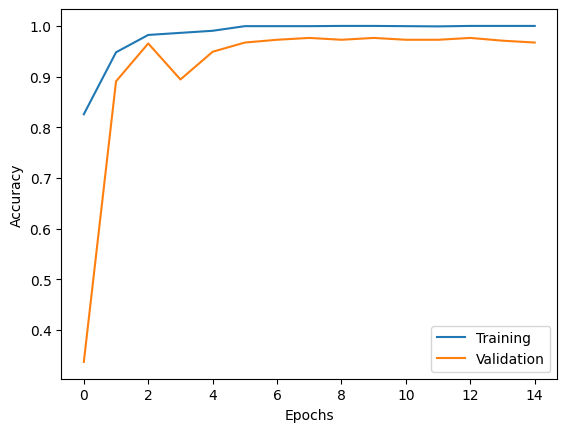

In [21]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


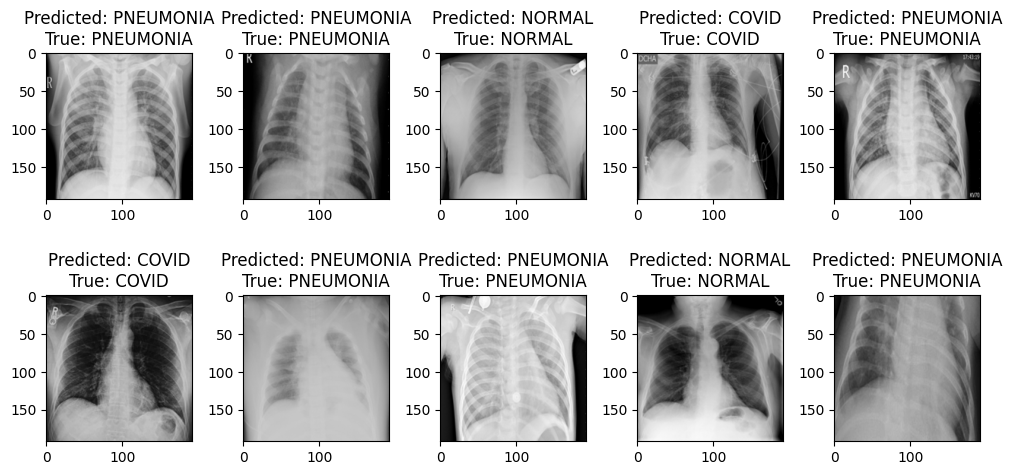

In [22]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step


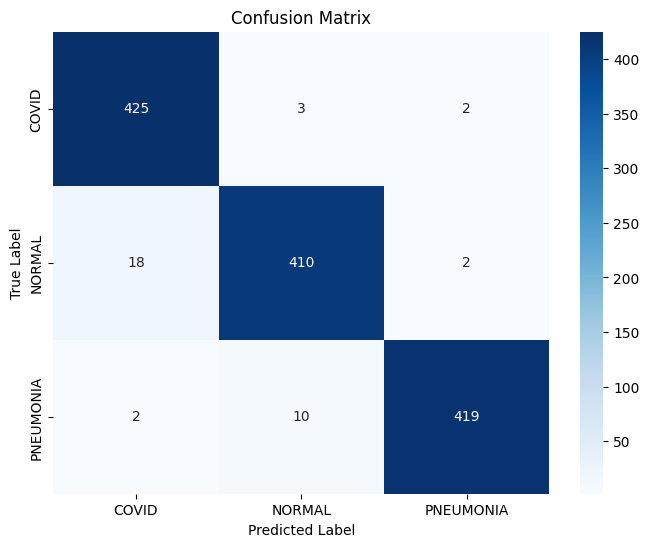

Accuracy:  0.9713400464756003
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       430
           1       0.97      0.95      0.96       430
           2       0.99      0.97      0.98       431

    accuracy                           0.97      1291
   macro avg       0.97      0.97      0.97      1291
weighted avg       0.97      0.97      0.97      1291



In [23]:
predictions = model.predict(X_test)#calculate the predictions for the test set
predicted_classes = np.argmax(predictions, axis=1)#extract the most probable classes

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes)#calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1) # turn the test labels into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes)#calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on ResNET50 with transfert learning (to modify)

The ResNET50 model has a very good accuracy of 93%.
It still has some confusion (mostly between Normal and Covid pictures) and could benefit more training (it seems undertrained here).

## InceptionV3 transfert model

In [ ]:
# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model InceptionV3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 95, 95, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 95, 95, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 95, 95, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 93, 93, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 93, 93, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 93, 93, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 93, 93, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 93, 93, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 93, 93, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 46, 46, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 46, 46, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 46, 46, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 46, 46, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 95, 95, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 95, 95, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 95, 95, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 93, 93, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 93, 93, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 93, 93, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 93, 93, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 93, 93, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 93, 93, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 46, 46, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 46, 46, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 46, 46, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 46, 46, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 95, 95, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 95, 95, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 95, 95, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 93, 93, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 93, 93, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 93, 93, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 93, 93, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 93, 93, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 93, 93, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 46, 46, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 46, 46, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 46, 46, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 46, 46, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Fit InceptionV3 model with frozen ImageNet weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'):
  from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])#compiling

  model.fit(X_train, y_train,batch_size=4,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr])#training

Epoch 1/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6575 - loss: 2.0023
Epoch 1: val_acc improved from -inf to 0.76685, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - acc: 0.6578 - loss: 2.0002 - val_acc: 0.7668 - val_loss: 1.2187 - learning_rate: 0.0100
Epoch 2/15
547/548 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8073 - loss: 0.9723
Epoch 2: val_acc improved from 0.76685 to 0.87067, saving model to best_model.keras
548/548 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - acc: 0.8073 - loss: 0.9721 - val_acc: 0.8707 - val_loss: 0.5446 - learning_rate: 0.0100
Epoch 3/15
546/548 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8315 - loss: 0.8112
Epoch 3: val_acc did not improve from 0.87067
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - acc: 0.8315 - loss: 0.8114 - val_acc: 0.8397 - val_loss: 0.7433 - learning_rate: 0.0100
Epoch 4/15
545/548 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8490 - loss: 0.6425
Epoch 4: val_acc did not improve from 0.87067

Epoch 4: Reduce

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455, 0.0012499999720603228, 0.0012499999720603228, 0.0012499999720603228, 0.0012499999720603228, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513]
Best model epoch: 13


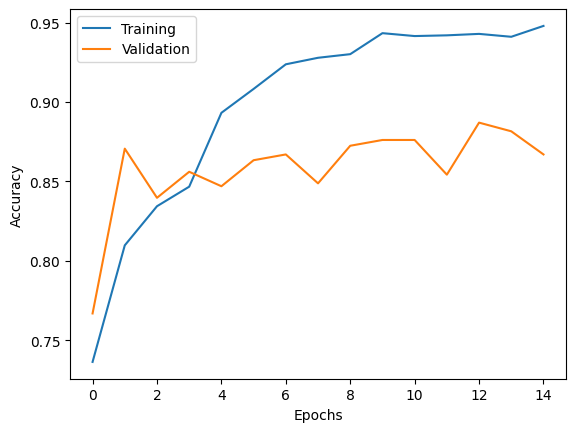

In [ ]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


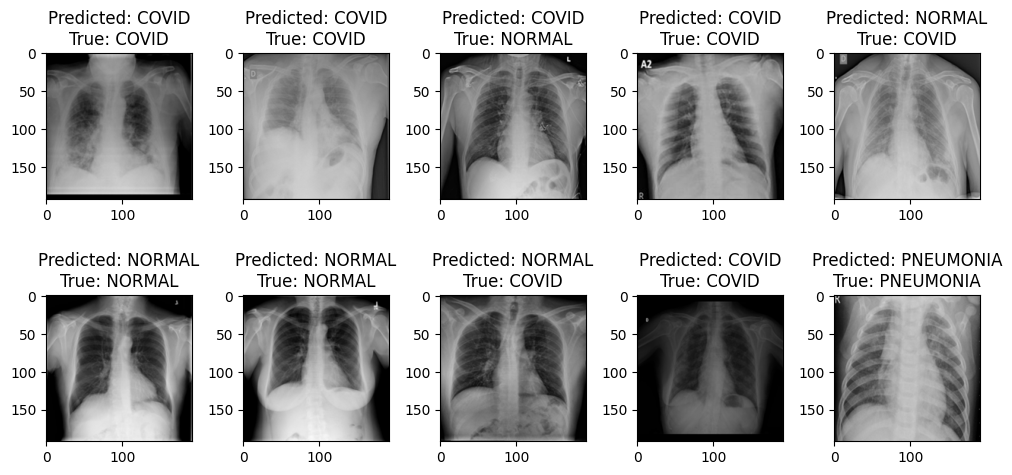

In [ ]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step


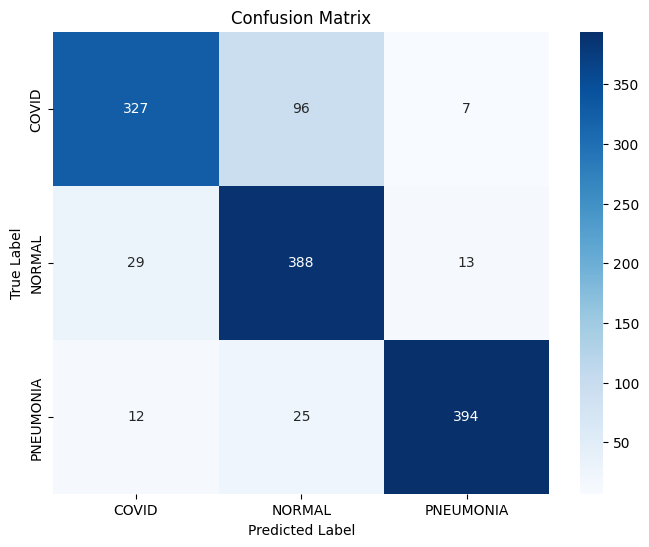

Accuracy:  0.8590240123934935
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82       430
           1       0.76      0.90      0.83       430
           2       0.95      0.91      0.93       431

    accuracy                           0.86      1291
   macro avg       0.87      0.86      0.86      1291
weighted avg       0.87      0.86      0.86      1291



In [ ]:
predictions = model.predict(X_test)#calculate the prediction on the test set
predicted_classes = np.argmax(predictions, axis=1) #extract the most probable classes

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes) #calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1)#turn the test labels into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes)# calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

### Comments on InceptionV3 with transfert learning

The transfert learning has decreased the model accuracy (for the same training). This may be due to the fact that the pre-training was done on imagenet, and freezing less convolutional layers does improve the model.

##General Comment on transfert models

Transfert learnings seems pretty efficient at improving VGG16 while freezing the convolutional layers. However for the two other models, freezing the convolutional layer while training them gives worse results (terrible results for ResNET50). This may be due to the fact that the pre-training is done on a different type of training dataset (imagenet), different from our xrays pictures. However, unfreezing the convolutional layers while using pre-training is very powerful at improving the results for ResNET50 and InceptionV3, for instance ResNET with transfert learning used that way reached 97% accuracy for the same amount of learning.

# Augmentation

## Augmenting the data

In [6]:
import torch
from torchvision import transforms
from PIL import Image

# 1. Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# 2. Convert X_train to a list of PIL images (since transforms work with PIL images)
X_train_pil = [Image.fromarray((img * 255).astype(np.uint8)) for img in X_train]


In [8]:
# 3. Apply augmentations and create the augmented dataset
num_augmentations = 1  # Number of augmentations per image
augmented_images = []
augmented_labels = []

for i, image in enumerate(X_train_pil):
    for _ in range(num_augmentations):
        transformed_image = transform(image)  # Apply transformations
        augmented_images.append(transformed_image.numpy())  # Convert tensor to NumPy array
        augmented_labels.append(y_train.iloc[i].values)  # Use corresponding label

In [9]:
# 4. Convert lists of augmented images and labels back to NumPy arrays
X_augmented = np.array(augmented_images)  # Shape: (num_samples * num_augmentations, 3, 224, 224)
y_augmented = np.array(augmented_labels)  # Shape: (num_samples * num_augmentations, 3)

# Print shapes to verify
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

X_augmented shape: (2741, 3, 192, 192)
y_augmented shape: (2741, 3)


## See what the augmentations look like

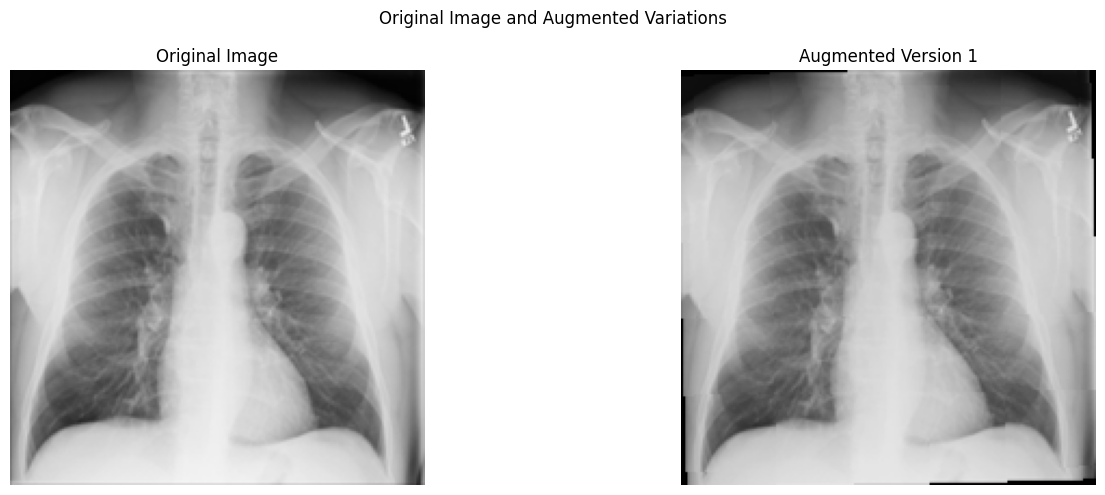

In [10]:
original_image = X_train_pil[0]  # Use the first image in the dataset

# Set up plot
fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 5))
fig.suptitle("Original Image and Augmented Variations")

# Show the original image (without any transformations)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate and display augmented versions of the image
for i in range(num_augmentations):
    augmented_image = transform(original_image)  # Apply transformations
    # Convert tensor to numpy and denormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    augmented_image = augmented_image * std + mean  # Denormalize
    augmented_image = augmented_image.numpy().transpose(1, 2, 0)  # Convert to HxWxC format
    augmented_image = np.clip(augmented_image, 0, 1)  # Clip values to valid range
    # Display the augmented image
    axes[i + 1].imshow(augmented_image)
    axes[i + 1].set_title(f"Augmented Version {i + 1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Reshaping X_augmented to match the shape of X_train
X_augmented_reshaped = X_augmented.transpose(0, 2, 3, 1)

# Check the shape of the combined array
print(X_train.shape)
print(X_augmented_reshaped.shape)

(2741, 192, 192, 3)
(2741, 192, 192, 3)


In [12]:
# Concatenate original images with augmented images to include both
X_combined = np.concatenate([X_train, X_augmented_reshaped], axis=0)

# Concatenate the corresponding labels
y_combined = np.concatenate([y_train, y_augmented], axis=0)

In [13]:
#Clear objects from memory
del(X_train)
del(y_train)
del(X_augmented)
del(y_augmented)
del(X_augmented_reshaped)

## Using augmented data on the best previous model

In [14]:
# load ResNET50 model new input layer shape.
IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model ResNet50
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# Add new GAP layer and output layer to non-froozen layers of original model with adjusted input


# Getting output tensor of the last ResNET50 layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the ResNET50 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 192, 192, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 198, 198, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 96, 96, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 96, 96, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 96, 96, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 98, 98, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 48, 48, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 48, 48, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 48, 48, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 48, 48, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 48, 48, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 48, 48, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# Fit ResNET50 model with non-frozen ImageNet weights and new input/output layer shapes (outputs have trainable parameters)
with tf.device('/device:GPU:0'):
  from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

  mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])#compiling

  model.fit(X_combined, y_combined,batch_size=8,
          epochs = 15, verbose=1,validation_split=.2,callbacks=[mc,red_lr])#fiting

Epoch 1/15
549/549 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - acc: 0.7574 - loss: 0.6102
Epoch 1: val_acc improved from -inf to 0.84047, saving model to best_model.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 114s 134ms/step - acc: 0.7575 - loss: 0.6099 - val_acc: 0.8405 - val_loss: 0.4184 - learning_rate: 0.0100
Epoch 2/15
548/549 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - acc: 0.9348 - loss: 0.1895
Epoch 2: val_acc did not improve from 0.84047
549/549 ━━━━━━━━━━━━━━━━━━━━ 84s 74ms/step - acc: 0.9348 - loss: 0.1894 - val_acc: 0.7976 - val_loss: 0.6058 - learning_rate: 0.0100
Epoch 3/15
548/549 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 0.9601 - loss: 0.1056
Epoch 3: val_acc improved from 0.84047 to 0.92525, saving model to best_model.keras
549/549 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - acc: 0.9601 - loss: 0.1056 - val_acc: 0.9253 - val_loss: 0.1715 - learning_rate: 0.0100
Epoch 4/15
548/549 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - acc: 0.9852 - loss: 0.0455
Epoch 4: val_acc improved from 0.92525 to 0.95807, saving m

Learning rates: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.0024999999441206455, 0.0024999999441206455, 0.0012499999720603228, 0.0012499999720603228]
Best model epoch: 9


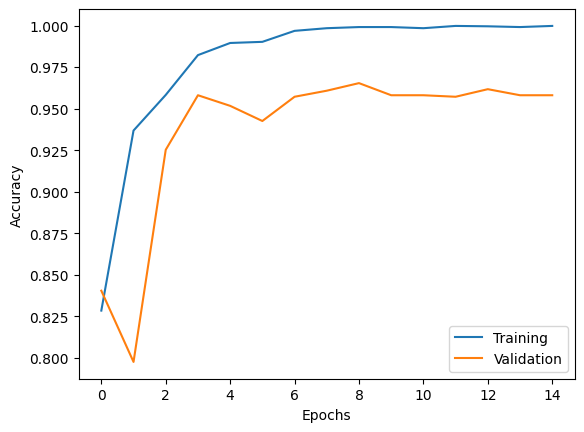

In [17]:
#Extract learning rate callback
learning_rates=model.history.history['learning_rate'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print("Learning rates:", learning_rates)
print("Best model epoch:", best_model_epoch)

plot_accuracy(model)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step


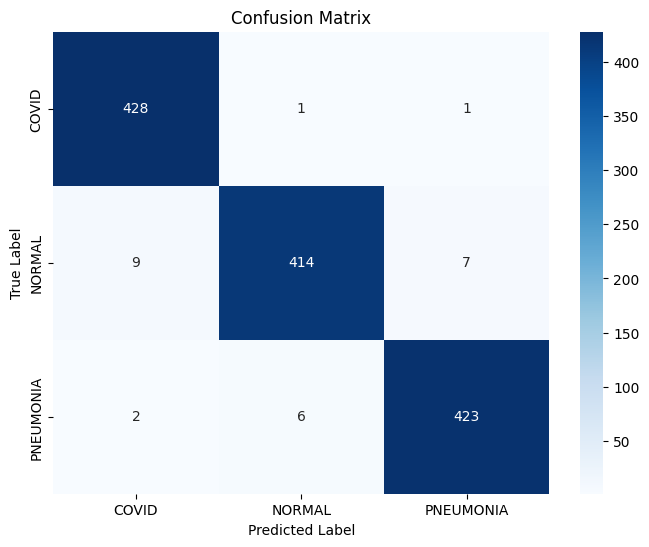

Accuracy:  0.9798605731990705
Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       430
           1       0.98      0.96      0.97       430
           2       0.98      0.98      0.98       431

    accuracy                           0.98      1291
   macro avg       0.98      0.98      0.98      1291
weighted avg       0.98      0.98      0.98      1291



In [21]:
predictions = model.predict(X_test)# calculate the prediction over the test set
predicted_classes = np.argmax(predictions, axis=1)# extract the most probable classes

cm = confusion_matrix(y_test.values.argmax(axis=1), predicted_classes)# calculate the confusion matrix

#represent the confusion matrix
class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_test_list = np.argmax(y_test.values, axis=1)#turn the test labels into a list
accuracy = accuracy_score(y_test_list, predicted_classes) #https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
classification = classification_report(y_test_list, predicted_classes)# calculate the classification report

print("Accuracy: ",accuracy)
print("Classification report:\n", classification)

## General comment on data augmentation

Doubling the dataset with data augmentation improved the accuracy of our best model by 1% (thus reaching 98%). More data augmentation and training could be done, but this requires a lot of RAM and is therefore technically limited.

Thus, ResNET50 with transfert learning and a doubling of the data is our best model with 98% accuracy.

We think that playing a bit more with the hyperparmeters and using for more computing power could still improve the model above 99% accuracy. Increasing the data augmentation could be a first step towards that.